# Import Statements

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from copy import deepcopy
import numpy as np
from graph_util.visualization_util import make_graph_visual
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from scheduling_util.heuristics import native_rescheduler
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize

# Training Data

In [2]:
feature_id = ['constant', 'num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels']    

# Function to get list of feature sets. A feature set is in the form [x1, x2, ..., y] where y is psize
def get_feature_set(G):
    lst = []
    
    # Get attributes for graph G
    out_bet_lst = nx.algorithms.out_degree_centrality(G)
    trophic_lst = nx.algorithms.trophic_levels(G)
    
    # Create feature set for each node in G
    for node in G.nodes:
        out_bet = out_bet_lst[node]
        trophic = trophic_lst[node]
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        
        lst.append({
            "constant": 1,
            "num_descendants": float(len(descendants)),
            "out_degree_betweenness_centrality": float(out_bet),
            "trophic_levels": float(trophic),
        })   
        
    return lst

Create training data with given parameters

In [3]:
df = pd.DataFrame(columns = ["graph_object", "num_tasks", "num_machines", "weights", "order", "features", "psize", "gd_cost", "lr_cost"])

# parameters
num_tasks_lst = [15, 25, 35, 45, 55, 65, 75]
num_machines_lst = [3, 6, 8]
copies = 10
tie_breaking_rule = 2
probability = 0.3
count = 0
for num_tasks in num_tasks_lst: # number of tasks
    for num_machines in num_machines_lst:  # number of machines
        for k in range(copies):    # number of copies
            count += 1
            print(count)
            w = [1 for _ in range(num_tasks)] # weight
            s = [1 for _ in range(num_tasks)] # speed
            p = [1 for _ in range(num_tasks)] # ?
            G, _ = er_dag(num_tasks, probability)
            assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
            etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
            intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
            if speeds[0] != -1:
                entry_dict = {
                    "graph_object": G,
                    "num_tasks": num_tasks,
                    "num_machines": num_machines,
                    "weights": w,
                    "order": etf.order,
                    "features": get_feature_set(G),
                    "psize": speed_to_psize(speeds),
                    "gd_cost": np.inf,
                    "lr_cost": np.inf,
                    "opt_cost": obj_value,
                }
                assert(len(entry_dict["features"]) == len(entry_dict["psize"]))
                df = df.append(entry_dict, ignore_index = True)
                

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


In [4]:
df

,graph_object,num_tasks,num_machines,weights,order,features,psize,gd_cost,lr_cost,opt_cost
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 5, 8, 10, 12], [1, 3, 2, 13, 11], [4, 6, ...","[{'constant': 1, 'num_descendants': 12.0, 'out...","[5.000009044899999, 5.000009044899999, 2.99999...",inf,inf,50.29399
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 2, 9, 10, 7], [1, 5, 8, 13, 12], [3, 4, 6...","[{'constant': 1, 'num_descendants': 9.0, 'out_...","[5.000009044899999, 5.000009044899999, 4.00004...",inf,inf,50.29399
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 2, 3, 6, 5, 9], [7, 10, 4, 8, 11], [1, 12...","[{'constant': 1, 'num_descendants': 4.0, 'out_...","[5.6689705215999995, 5.6689705215999995, 8.337...",inf,inf,52.29241
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[5, 1, 2, 8, 9, 10, 11, 12], [0, 4, 6, 7, 13,...","[{'constant': 1, 'num_descendants': 14.0, 'out...","[7.4999847321, 12.999990802500001, 6.000001260...",inf,inf,59.04993
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[5, 2, 4, 6, 7, 9, 13, 14], [3, 8, 11, 12], [...","[{'constant': 1, 'num_descendants': 8.0, 'out_...","[2.5149202225, 1.5148932561, 8.970204700899998...",inf,inf,54.61936
...,...,...,...,...,...,...,...,...,...,...
167,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1, 5, 7, 11, 16, 14, 24, 20, 21, 23, 27, 30,...","[{'constant': 1, 'num_descendants': 70.0, 'out...","[22.5654450961, 22.5654450961, 22.5654450961, ...",inf,inf,493.73443
168,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[7, 4, 5, 8, 21, 12, 13, 15, 20, 28, 31, 34, ...","[{'constant': 1, 'num_descendants': 70.0, 'out...","[20.436728489999997, 27.21604561, 20.436728489...",inf,inf,519.93050
169,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0, 6, 7, 14, 15, 21, 25, 29, 27, 32, 35, 36,...","[{'constant': 1, 'num_descendants': 71.0, 'out...","[30.979465446400003, 21.276078759999997, 11.16...",inf,inf,488.22336
170,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0, 3, 4, 13, 15, 17, 19, 22, 24, 29, 33, 34,...","[{'constant': 1, 'num_descendants': 71.0, 'out...","[22.849834022499998, 22.849834022499998, 22.84...",inf,inf,529.93129


In [5]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# lr = LinearRegression()
# import numpy as np
# lr.fit(X, Y)
# print(f'R-Squared : {lr.score(X, Y)}')
# print(lr.get_params())
# print(lr.coef_)
# print(lr.intercept_)

# Train Model

In [6]:
def compute_cost(w, t, s):
    '''
    Given weights w, time intervals t, and speeds s, compute the cost of the schedule; 
    returns total cost as well as separate power and time components.
    '''
    power = 0
    time = 0
    #print(f"compute cost intervals are {t}")
    for j in range(len(s)):
        if t[j] == -1:
            return -1, -1, -1
        power += w[j] * s[j]
        time += t[j][1]
    total_cost = power + time
    return total_cost, power, time

def psize_to_speed(psize):
    return [np.sqrt(psize[i])for i in range(len(psize))]

#predict list of psizes for one graph G
def predict(coef, features):
    m = []
    for f in features:
        m.append(list(f.values()))
    return np.matmul(m, coef)

Train Linear Regression

In [7]:
df_features = pd.DataFrame(columns = feature_id)
df_psize = pd.DataFrame(columns = ["psize"])
for index, row in df.iterrows():
    for feature in row["features"]:
        df_features = df_features.append(feature, ignore_index=True)
    for psize in row["psize"]:
        df_psize = df_psize.append({"psize": psize}, ignore_index=True)
    
X = df_features[feature_id]
Y = df_psize[["psize"]]

In [8]:
# Train Linear Regression

import statsmodels.api as sm

model=sm.OLS(Y, X.astype(float)).fit()
print_model=model.summary()
print(print_model)

coefficients = np.array(model.params)
print(coefficients)


cost_lst = []
for index, row in df.iterrows():
    psizes = predict(coefficients, row["features"])
    speeds = psize_to_speed(psizes)
    time_intervals = native_rescheduler(deepcopy(row["graph_object"]), deepcopy(speeds), deepcopy(row["weights"]), deepcopy(row["order"]))
    cost, power, time = compute_cost(w, time_intervals, speeds)
    cost_lst.append(cost)
    
# update costs
new_df = pd.DataFrame({'lr_cost': cost_lst})
df.update(new_df)


                            OLS Regression Results                            
Dep. Variable:                  psize   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     4148.
Date:                Thu, 06 Jan 2022   Prob (F-statistic):               0.00
Time:                        00:09:47   Log-Likelihood:                -24497.
No. Observations:                7630   AIC:                         4.900e+04
Df Residuals:                    7626   BIC:                         4.903e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
consta

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


In [9]:
# print(df.iloc[0]["order"])
# G = df.iloc[0]["graph_object"]

# pos = nx.shell_layout(G)

# # print(pos)
# nx.draw(G, pos)
# nx.draw_networkx_labels(G, pos)
#make_graph_visual(df.iloc[1]["graph_object"], 15)

In [10]:
# r = df.iloc[0]
# native_rescheduler(r["graph_object"], r["weights"], r["weights"], r["order"])

Train Gradient Descent

In [11]:
# Functions for Gradient Descent Approach
def single_weight_update(coef, G, w, features, order):
    
    m = []
    for f in features:
        m.append(list(f.values()))
        
    curr_min_objective = np.inf
    curr_min_coef = deepcopy(coef)
    min_cost, min_power, min_time = np.inf, np.inf, np.inf
    all_combinations = list(product((-1, 1), repeat=len(coef)))
    for combo in all_combinations:
        temp_coef = deepcopy(coef)
        for i in range(len(combo)):
            temp_coef[i] += step_size * combo[i]
        psizes = np.matmul(m, temp_coef)
        speeds = psize_to_speed(psizes)
        time_intervals = native_rescheduler(deepcopy(G), deepcopy(speeds), deepcopy(w), deepcopy(order))
        cost, power, time = compute_cost(w, time_intervals, speeds)
#         print(f"Cost is {cost}, Power is {power}, time is {time}")
        if cost < min_cost:
            min_cost, min_power, min_time = cost, power, time
            curr_min_coef = deepcopy(temp_coef)
        
    return min_cost, min_power, min_time, curr_min_coef

In [12]:
# features = [{'constant': 1, 'num_descendants': 3.0, 'out_degree_betweenness_centrality': 0.25, 'trophic_levels': 1.0}, {'constant': 1, 'num_descendants': 1.0, 'out_degree_betweenness_centrality': 0.0, 'trophic_levels': 1.0}, {'constant': 1, 'num_descendants': 2.0, 'out_degree_betweenness_centrality': 0.25, 'trophic_levels': 2.0}, {'constant': 1, 'num_descendants': 1.0, 'out_degree_betweenness_centrality': 0.0, 'trophic_levels': 1.0}, {'constant': 1, 'num_descendants': 1.0, 'out_degree_betweenness_centrality': 0.0, 'trophic_levels': 3.0}]


    
# print(m)
# np.matmul(m, [1, 1, 1, 1])

In [13]:
MAX_ITER = 1000
step_size = 0.01
i = 0

# print(feature_id)
coef = [1 for _ in range(len(feature_id))] 

stopping_condition = 0.001


while i < MAX_ITER:
    
    cost_lst = []
    max_change = - np.infty
    for index, row in df.iterrows():
        new_cost, new_power, new_time, new_coef = single_weight_update(
            coef, 
            row["graph_object"], 
            row["weights"], 
            row["features"], 
            row["order"],
        )
        
        if row["gd_cost"] == np.inf: 
            change = - np.inf
            
        else:
            change = row["gd_cost"] - new_cost

        cost_lst.append(new_cost)
        max_change = max(change, max_change)
        coef = new_coef
    print(max_change)
    # update costs
    new_df = pd.DataFrame({'gd_cost': cost_lst})
    df.update(new_df)
    if max_change < stopping_condition and i > 1:
        print("Hit stopping condition with ", max_change)
        break
    i += 1
    

-inf
6.092796381906091
0.5655416769645853
0.6527534220497273


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


0.3454937906181783
0.7236346257543573
0.32643192707934077
0.527306608835147
0.6184515559471038
0.4422112956347064
0.3185695414019847
0.6780232721125685
0.6649626189344531
0.4935492036509572
0.6265296419498441
0.8156318898541031
0.37907307994558437
1.0812071993041172
0.7451722815724224
0.1553092523010946
0.5333744746808406
0.7288464962432499
0.525454903032653
0.7198463399013235
0.5552182754605042
11.167992777143965
0.2556365442474373
4.686057304535552
0.7228227236911664
2.726503860764751
0.23839131218960574
0.7268827117252386
3.9325561752866065
1.090147485126863
0.368765023653566
0.7098338530842057
9.440040238036886
0.8866709609129089
2.209488534112964
0.6050984951516227
0.538688651444204
0.7088758904339443
0.8186117298062072
0.13560284034895176
0.020826617015927695
0.027660842171485456
0.027537705813642788
0.38913275748302567
0.5460018029564253
7.425023913867761
0.9918183446332023
4.584321047765599
0.5783730384060846
1.2637833551516309
0.5853556076505697
1.2641074630194495
0.5814170290

In [14]:
df

,graph_object,num_tasks,num_machines,weights,order,features,psize,gd_cost,lr_cost,opt_cost
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 5, 8, 10, 12], [1, 3, 2, 13, 11], [4, 6, ...","[{'constant': 1, 'num_descendants': 12.0, 'out...","[5.000009044899999, 5.000009044899999, 2.99999...",inf,inf,50.29399
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 2, 9, 10, 7], [1, 5, 8, 13, 12], [3, 4, 6...","[{'constant': 1, 'num_descendants': 9.0, 'out_...","[5.000009044899999, 5.000009044899999, 4.00004...",inf,inf,50.29399
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 2, 3, 6, 5, 9], [7, 10, 4, 8, 11], [1, 12...","[{'constant': 1, 'num_descendants': 4.0, 'out_...","[5.6689705215999995, 5.6689705215999995, 8.337...",inf,inf,52.29241
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[5, 1, 2, 8, 9, 10, 11, 12], [0, 4, 6, 7, 13,...","[{'constant': 1, 'num_descendants': 14.0, 'out...","[7.4999847321, 12.999990802500001, 6.000001260...",inf,inf,59.04993
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[5, 2, 4, 6, 7, 9, 13, 14], [3, 8, 11, 12], [...","[{'constant': 1, 'num_descendants': 8.0, 'out_...","[2.5149202225, 1.5148932561, 8.970204700899998...",inf,inf,54.61936
...,...,...,...,...,...,...,...,...,...,...
167,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1, 5, 7, 11, 16, 14, 24, 20, 21, 23, 27, 30,...","[{'constant': 1, 'num_descendants': 70.0, 'out...","[22.5654450961, 22.5654450961, 22.5654450961, ...",518.015875,518.698703,493.73443
168,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[7, 4, 5, 8, 21, 12, 13, 15, 20, 28, 31, 34, ...","[{'constant': 1, 'num_descendants': 70.0, 'out...","[20.436728489999997, 27.21604561, 20.436728489...",549.169449,548.239246,519.93050
169,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0, 6, 7, 14, 15, 21, 25, 29, 27, 32, 35, 36,...","[{'constant': 1, 'num_descendants': 71.0, 'out...","[30.979465446400003, 21.276078759999997, 11.16...",508.239957,509.110337,488.22336
170,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",75,8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0, 3, 4, 13, 15, 17, 19, 22, 24, 29, 33, 34,...","[{'constant': 1, 'num_descendants': 71.0, 'out...","[22.849834022499998, 22.849834022499998, 22.84...",553.716809,553.898385,529.93129


In [15]:
# data = []
# greedy_objectives = []
# lr_objective = []
# lengths = []
# tie_breaking_rule = 2
# greedy_psizes = []
# lr_psizes = []
# # num_tasks = 15
# # num_machines = 3
# probability = 0.3
# coefficients_copy = deepcopy(coefficients)
# for i in range(1, 20):
#     print("I is ", i)
#     for k in range(5):  
#         num_tasks = i + 5
#         num_machines = 3
#         w = [1 for _ in range(num_tasks)]
#         s = [1 for _ in range(num_tasks)]
#         p = [1 for _ in range(num_tasks)]
#         G, _ = er_dag(num_tasks, probability)
#         assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
#         etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
#         intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
#         psize = speed_to_psize(speeds)
#         # print(f"Greedy psizes are {psize}")
#         cost, power, time = compute_cost(w, intervals, speeds)
#         print("Linear Regression")
#         print("_______________________")
#         if cost != -1:
#             greedy_objectives.append([cost, power, time])
#             feature_set = get_feature_set(G, psize)
#             # make_graph_visual(G, num_tasks)
#             # data = data + feature_set
#             df = pd.DataFrame.from_records(feature_set, columns=['num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])
#             X = df[['num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels']]
#             X['ones'] = 1
#             X = X[['ones','num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels' ]]
#             X = X.to_numpy()
#             X = np.transpose(X)
#             # Y = df[['psize']].to_numpy()
#             lr_cost, lr_power, lr_time, lr_min_coef = single_weight_update(coefficients, G, w, X, etf.order)
#             print(f"Coefficients: {lr_min_coef}")
#             coefficients = lr_min_coef
#             # X = sm.add_constant(X)
#             # lr_psize = lr.predict(feature_set)
#             # greedy_psizes.append(psize)
#             # lr_psizes.append(lr_psize)
#             # lr_speeds = psize_to_speed(lr_psize)
#             # lr_time_intervals = native_rescheduler(G, lr_speeds, w, etf.order)
#             # lr_cost, lr_power, lr_time = compute_cost(w,lr_time_intervals ,lr_speeds)
#             lr_objective.append([lr_cost, lr_power, lr_time])
#             lengths.append(len(G))
#             print(f"Greedy: {cost}  LR: {lr_cost} length: {lengths[-1]}")

# Set Trained Coefficients to linear model

In [16]:
# print(coefficients)
# lr.coef_ = coefficients

# Test the Model

In [17]:
# data = []
# greedy_objectives = []
# lr_objective = []
# lengths = []
# tie_breaking_rule = 2
# greedy_psizes = []
# lr_psizes = []
# # num_tasks = 15
# # num_machines = 3
# probability = 0.3

# for i in range(1, 20):
#     print("I is ", i)
#     for k in range(5):  
#         num_tasks = i + 5
#         num_machines = 3
#         w = [1 for _ in range(num_tasks)]
#         s = [1 for _ in range(num_tasks)]
#         p = [1 for _ in range(num_tasks)]
#         G, _ = er_dag(num_tasks, probability)
#         assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
#         etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
#         intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
#         psize = speed_to_psize(speeds)
#         cost, power, time = compute_cost(w, intervals, speeds)
#         if cost != -1:
#             greedy_objectives.append([cost, power, time])
#             feature_set = get_feature_set(G, psize)
#             # make_graph_visual(G, num_tasks)
#             # data = data + feature_set
#             df = pd.DataFrame.from_records(feature_set, columns=['num_descendants',  'out_degree_betweenness_centrality', 'trophic_levels','psize'])
#             X = df[[ 'num_descendants',  'out_degree_betweenness_centrality', 'trophic_levels']]
#             X = sm.add_constant(X)
#             lr_psize = lr.predict(feature_set)
#             greedy_psizes.append(psize)
#             lr_psizes.append(lr_psize)
#             lr_speeds = psize_to_speed(lr_psize)
#             lr_time_intervals = native_rescheduler(G, lr_speeds, w, etf.order)
#             lr_cost, lr_power, lr_time = compute_cost(w,lr_time_intervals ,lr_speeds)
#             lr_objective.append([lr_cost, lr_power, lr_time])
#             lengths.append(len(G))

# Graph the results

In [18]:
df["lr_cost"] / df["gd_cost"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
167    1.001318
168    0.998306
169    1.001713
170    1.000328
171    0.999670
Length: 172, dtype: float64

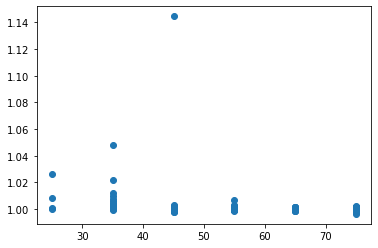

In [19]:
plt.scatter(df["num_tasks"], df["lr_cost"] / df["gd_cost"])

In [20]:
# objective_comparisons = [g[0]/l[0] for g, l in zip(greedy_objectives, lr_objective)]
# power_comparisons = [g[1]/l[1] for g, l in zip(greedy_objectives, lr_objective)]
# time_comparisons = [g[2]/l[2] for g, l in zip(greedy_objectives, lr_objective)]

# print("objective ratio \n", objective_comparisons)
# print("power comparisons \n", power_comparisons)
# print("time comparisons \n", time_comparisons)

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # # Run model on test data and visualize prediction accuracy
# # y_hat = lr.predict(X_test)
# # print("predictions are ",y_hat)
# # plt.figure(figsize=(16,8))
# # sns.distplot(y_hat, hist = False, label = f'Predicted Pseudosize')
# # sns.distplot(Y_test, hist = False, label = f'Actual Pseudosize')
# # plt.title(f'Actual vs Predicted Pseudosize')
# # plt.xlabel('Pseudosize')
# # plt.ylabel('Density')
# # plt.show()
# plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths})

# plt.figure(figsize=(16,8))
# sns.lmplot("size", "objective_ratio", plt_df, order=1)
# plt.title("Ratio of Total Objective of Greedy/Linear Regression")
# plt.xlabel("Size of Graph")
# plt.ylabel("Greedy/Linear Regression Total Ratio")
# plt.show()

# plt.figure(figsize=(16,8))
# sns.lmplot("size", "power_ratio", plt_df, order=1)
# plt.title("Ratio of Power Objective of Greedy/Linear Regression")
# plt.xlabel("Size of Graph")
# plt.ylabel("Greedy/Linear Regression Power Ratio")
# plt.show()

# plt.figure(figsize=(16,8))
# sns.lmplot("size", "time_ratio", plt_df, order=1)
# plt.title("Ratio of Time Objective of Greedy/Linear Regression")
# plt.xlabel("Size of Graph")
# plt.ylabel("Greedy/Linear Regression Time Ratio")
# plt.show()